## Quality Control for MALDI Data 
Used for Figure 6 

Author: Max Gold

In [1]:
import numpy as np
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats
from sklearn.cluster import KMeans


In [ ]:
base_fold = '../../data/'

In [4]:
adata = sc.read_h5ad(os.path.join(base_fold, "maldi_data.h5ad"))

adata.var['name'] = adata.var.index

adata.var.index = list(map(int, range(adata.var.shape[0])))

In [5]:
adata

AnnData object with n_obs × n_vars = 88410 × 4677
    obs: 'x', 'y', 'tx', 'ty'
    var: 'Formula', 'mz', 'mz_neg', 'score', 'annotation', 'Detected', 'name'
    obsm: 'spatial'

### Map to metabolites with 2 PPM

In [5]:
## process metabolites
cdf = pd.read_csv(os.path.join(base_fold, "P1_neg_ionization.csv"), index_col=0)

def get_index_ppm(v, ims):
    val = ((abs((v - ims.var[['mz_neg']])) / ims.var[['mz_neg']] ) * 1E6)
    val.columns = ['ppm']
    val= val.join(ims.var)
    xdf = val.sort_values('ppm').head(1)
    i = int(xdf.index[0])
    ppm = float(list(xdf['ppm'])[0])
    return(i,ppm)

ppl = []
for index, row in cdf.iterrows():
    vv = row['mz_neg']
    i,ppm = get_index_ppm(vv, adata)
    ppl.append([index, i, ppm])
ppldf = pd.DataFrame(ppl, columns = ['name', 'index', 'ppm'])

ppmv = 2
ppldf[ppldf['ppm']<ppmv].shape

idict = dict([[row['index'], row['name']] for ind,row in ppldf[ppldf['ppm']<ppmv].iterrows()])

# ml = [idict[x] if x in idict.keys() else 'unknown-' + str(x) for x in range(o.var.shape[0]) ]
ml = [idict[x] if x in idict.keys() else 'unknown-' + str(round(float(adata.var.loc[x,'mz']), 5)) for x in range(adata.var.shape[0]) ]

adata.var['metabolite'] = ml

In [6]:
points = adata.obs[['x', 'ty']].values

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10, random_state=100, n_init=100).fit(points)

adata.obs['clust'] = kmeans.labels_

In [8]:
## process samples

xk = kmeans.cluster_centers_.tolist()

setnum = -200
txk = [x for x in xk if x[1] > setnum]
bxk = [x for x in xk if x[1] < setnum]
tempt = sorted(txk)   
tempb = sorted(bxk)  

td = dict([[ii,tempt.index(i)] for ii,i in enumerate(txk)])
bd = dict([[ii,tempb.index(i)] for ii,i in enumerate(bxk)])


fld = {}
for i,x in enumerate(xk):
    if x in txk:
        fld[i] = tempt.index(x)
    else:
        fld[i] = tempb.index(x) + 5
        
adata.obs['clust_ord'] = [fld[x] for x in adata.obs['clust']]

# sns.lmplot(data=o.obs, x='x', y='ty', hue='clust_', fit_reg=False, aspect=2)

sd = {0: 'MB0595', 1: 'MB2112', 2: 'MB4143', 3: 'MB0601_A', 4: 'MDT-AP-2377', 
      5: 'MB0601_B', 6: 'MB3201', 7: 'MB3400', 8: 'MDT-AP-0388', 9: 'MB3612'}
sal = ['MB3201', 'MB4143', 'MDT-AP-0388', 'MDT-AP-2377']

adata.obs['sample'] = [sd[x] for x in adata.obs['clust_ord']]
adata.obs['subtype'] = ['SHHa' if x in sal else 'SHHb' for x in adata.obs['sample']]

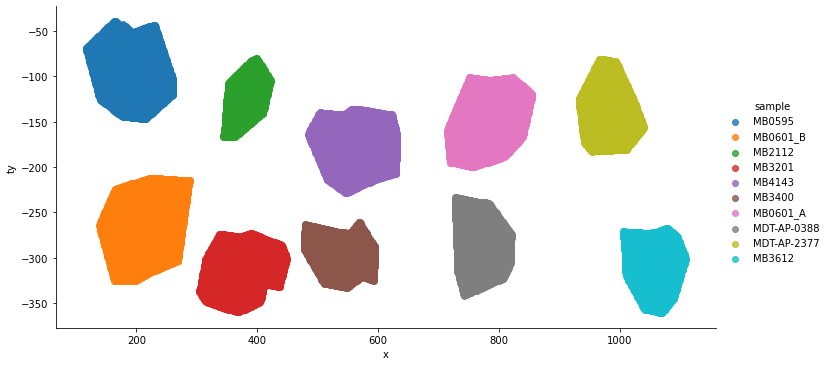

In [9]:
sns.lmplot(data=adata.obs, x='x', y='ty', hue='sample', fit_reg=False, aspect=2)

### TIC normalize data

In [37]:
adata_tic = adata.copy()

/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [38]:
tic_vals = adata_tic.X / adata_tic.X.sum(axis=1).reshape(-1,1)

In [39]:
adata_tic.X = tic_vals

In [40]:
atc = adata_tic.copy()

In [41]:
sc.pp.scale(atc)
sc.tl.pca(atc, svd_solver='arpack')
sc.pp.neighbors(atc, n_neighbors=10, n_pcs=10)
sc.tl.leiden(atc, resolution=0.2)

In [42]:
badclust = ['2', '4', '9', '10','11', '12', '13', '14']
good = atc[~atc.obs['leiden'].isin(badclust)]

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
sc.pl.scatter(good, x='x', y='ty', color='leiden', ax=ax, size=3)

In [50]:
good.obs['sample'].unique().tolist()

['MB0595',
 'MB0601_B',
 'MB2112',
 'MB3201',
 'MB4143',
 'MB3400',
 'MB0601_A',
 'MDT-AP-0388',
 'MDT-AP-2377',
 'MB3612']

In [287]:
bad_combos = ['MB3612_8', 'MDT-AP-2377_8', 'MDT-AP-0388_8', 'MB0601_A_3','MB0601_A_8', 'MB3400_0', 'MB4143_7', 'MB4143_8', 
              'MB3201_8', 'MB2112_3','MB0601_B_3', 'MB0601_B_8']

In [288]:
samps = good.obs['sample'].tolist()
clust = good.obs['leiden'].tolist()
cnames = ['_'.join(x) for x in zip(samps, clust)]
good.obs['sampclust'] = cnames
rgood = good[~good.obs['sampclust'].isin(bad_combos)]

/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sampclust' as categorical


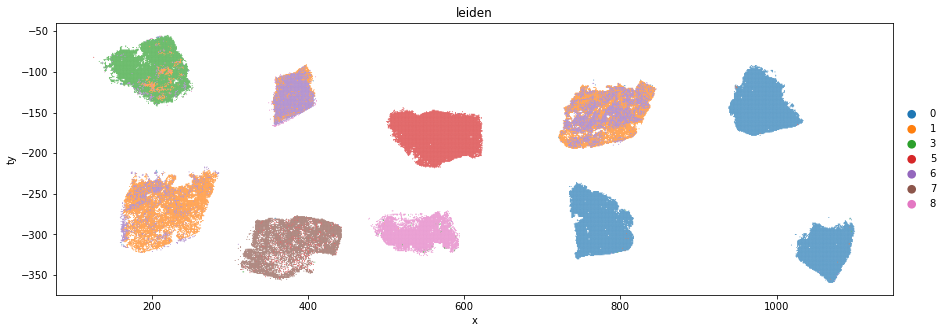

In [289]:
fig,ax = plt.subplots(figsize=(15,5))
sc.pl.scatter(rgood, x='x', y='ty', color='leiden', ax=ax, size=3)

In [290]:
rgood.obs['sample'] = rgood.obs['sample'].cat.reorder_categories(list(sd.values()))

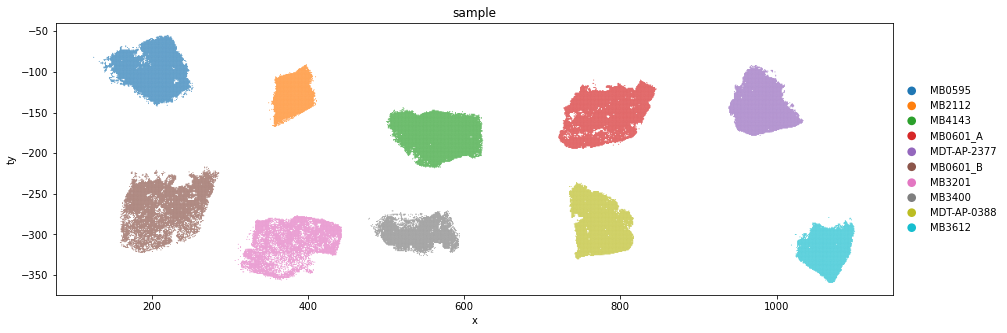

In [291]:
fig,ax = plt.subplots(figsize=(15,5))
sc.pl.scatter(rgood, x='x', y='ty', color='sample', ax=ax, size=3)

In [370]:
rgood.shape

(52393, 4677)

## find high quality metabs
Look for ones higher than 1E5 in greater than 50% of spots

In [292]:
groox = np.where(adata_tic.X >= 1e5, adata_tic.X, 0)

In [293]:
rff = adata.copy()

/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [294]:
rff = rff[rgood.obs.index,:]

In [295]:
groox = np.where(rff.X >= 1e5, rff.X, 0)

In [296]:
tff = np.count_nonzero(groox,axis=0) > (groox.shape[0]*0.5)

In [297]:
rff.var['expressed'] = ['1' if x == True else '0' for x in tff]

Trying to set attribute `.var` of view, copying.


In [298]:
gv = np.array(rff.var.index)[tff]

In [299]:
coo = adata_tic.copy()
coo.var['expressed'] = ['1' if x == True else '0' for x in tff]
coo = coo[rgood.obs.index, gv]

In [300]:
io = [str(index) for index,row in coo.var.iterrows() if ((row['expressed']=='1') & ('unk' not in row['metabolite']))]

In [302]:
goq = coo[:, io]

In [303]:
goq.write_h5ad(os.path.join(base_fold, "maldi_data_vf.h5ad"))

/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` o